In [1]:
from constants import *
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, cross_val_score, train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
import numpy as np
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_train = pd.read_csv(PATH_DF_TRAIN)
df_test = pd.read_csv(PATH_DF_TEST)

In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18850 entries, 0 to 18849
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18850 non-null  int64  
 1   id                        18850 non-null  object 
 2   start_date                18850 non-null  object 
 3   end_date                  18850 non-null  object 
 4   created_on                18850 non-null  object 
 5   latitud                   18133 non-null  float64
 6   longitud                  18133 non-null  float64
 7   place_l2                  18850 non-null  object 
 8   place_l3                  18755 non-null  object 
 9   place_l4                  740 non-null    object 
 10  place_l5                  0 non-null      float64
 11  place_l6                  0 non-null      float64
 12  operation                 18850 non-null  object 
 13  property_type             18850 non-null  object 
 14  proper

Hacemos el mismo "tratamiento" al df_test que el que ya le hicimos al df_train

In [4]:
df_test.drop(columns=["id", "start_date", "end_date", "created_on", "place_l2", "place_l4", "place_l5", "place_l6", "operation", "property_currency", "property_title"], inplace=True)

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18850 entries, 0 to 18849
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18850 non-null  int64  
 1   latitud                   18133 non-null  float64
 2   longitud                  18133 non-null  float64
 3   place_l3                  18755 non-null  object 
 4   property_type             18850 non-null  object 
 5   property_rooms            18650 non-null  float64
 6   property_bedrooms         16594 non-null  float64
 7   property_surface_total    17860 non-null  float64
 8   property_surface_covered  18158 non-null  float64
 9   property_price            18850 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
df_test.head(3)

,Unnamed: 0,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,446819,-34.600813,-58.497620,Villa del Parque,Departamento,1.0,NaN,45.0,41.0,130000.0
1,135148,-34.556298,-58.439923,Belgrano,Departamento,5.0,3.0,175.0,141.0,579000.0
2,445316,-34.612908,-58.386174,Congreso,Departamento,1.0,NaN,25.0,NaN,49000.0


Veo que la columna unnamed es la indicadora de la fila del csv, la borramos

In [7]:
df_test.drop(columns=["Unnamed: 0"], inplace=True)

In [8]:
df_test.head(3)

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,-34.600813,-58.497620,Villa del Parque,Departamento,1.0,NaN,45.0,41.0,130000.0
1,-34.556298,-58.439923,Belgrano,Departamento,5.0,3.0,175.0,141.0,579000.0
2,-34.612908,-58.386174,Congreso,Departamento,1.0,NaN,25.0,NaN,49000.0


In [9]:
df_test[(df_test["property_bedrooms"].isnull()) & (df_test["property_rooms"].isnull())].shape

(81, 9)

In [10]:
df_test[(df_test["property_bedrooms"].notnull()) & (df_test["property_rooms"].isnull())].shape

(119, 9)

In [11]:
df_test[(df_test["property_bedrooms"].isnull()) & (df_test["property_rooms"].notnull())].shape

(2175, 9)

In [12]:
#1. Eliminar las filas donde ambos datos son null ya que no contamos con la información suficiente para imputar al otro dato. En una futura versión estos datos podrían llegar a imputarse en base a publicaciones de similares características.
df_test.dropna(subset=["property_bedrooms", "property_rooms"], inplace=True)

#2. Imputar la cantidad de habitaciones como cantidad de ambientes - 1
df_test["property_bedrooms"].fillna(df_test["property_rooms"] - 1, inplace=True)

#3. Imputar la cantidad de ambientes como cantidad de habitaciones + 1
df_test["property_rooms"].fillna(df_test["property_bedrooms"] + 1, inplace=True)

In [13]:
df_test.isnull().sum()

latitud                     605
longitud                    605
place_l3                     48
property_type                 0
property_rooms                0
property_bedrooms             0
property_surface_total      826
property_surface_covered    548
property_price                0
dtype: int64

In [14]:
df_test[(df_test["property_surface_covered"].isnull()) & (df_test["property_surface_total"].isnull())].shape

(0, 9)

In [15]:
df_test[(df_test["property_surface_covered"].notnull()) & (df_test["property_surface_total"].isnull())].shape

(826, 9)

In [16]:
df_test[(df_test["property_surface_covered"].isnull()) & (df_test["property_surface_total"].notnull())].shape

(548, 9)

In [17]:
#1. Eliminar las filas donde ambos datos son null ya que no contamos con la información suficiente para imputar al otro dato. En una futura versión estos datos podrían llegar a imputarse en base a publicaciones de similares características.
df_test.dropna(subset=["property_surface_covered", "property_surface_total"], inplace=True)

#2. Imputar la superficie cubierta como superficie total
df_test["property_surface_covered"].fillna(df_test["property_surface_total"], inplace=True)

#3. Imputar superficie total como superficie cubierta
df_test["property_surface_total"].fillna(df_test["property_surface_covered"], inplace=True)

In [18]:
df_test[df_test["property_price"] <= 0].shape

(0, 9)

In [19]:
df_test[df_test["property_surface_covered"] <= 0].shape

(0, 9)

In [20]:
df_test[df_test["property_surface_total"] <= 0].shape

(0, 9)

In [21]:
df_test[df_test["property_surface_total"] < df_test["property_surface_covered"]].shape

(31, 9)

In [22]:
filas_erroneas = df_test["property_surface_total"] < df_test["property_surface_covered"]

In [23]:
df_test.loc[filas_erroneas, ["property_surface_total", "property_surface_covered"]] = df_test.loc[filas_erroneas, ["property_surface_covered", "property_surface_total"]].values

In [24]:
mediana = df_test["property_surface_total"].median()

limite_superior = mediana * 7

df_test = df_test[df_test["property_surface_total"] <= limite_superior]

In [25]:
df_test.isnull().sum()

latitud                     539
longitud                    539
place_l3                     36
property_type                 0
property_rooms                0
property_bedrooms             0
property_surface_total        0
property_surface_covered      0
property_price                0
dtype: int64

In [26]:
df_test[(df_test["latitud"].isnull()) & (df_test["longitud"].isnull())].shape

(539, 9)

In [27]:
df_test.dropna(subset=["latitud", "longitud", "place_l3"], inplace=True)

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55059 entries, 0 to 55058
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                55059 non-null  int64  
 1   latitud                   55059 non-null  float64
 2   longitud                  55059 non-null  float64
 3   property_rooms            55059 non-null  float64
 4   property_bedrooms         55059 non-null  float64
 5   property_surface_total    55059 non-null  float64
 6   property_surface_covered  55059 non-null  float64
 7   property_price            55059 non-null  float64
 8   total_m2_price            55059 non-null  float64
 9   covered_m2_price          55059 non-null  float64
 10  Casa                      55059 non-null  int64  
 11  Departamento              55059 non-null  int64  
 12  PH                        55059 non-null  int64  
 13  Palermo                   55059 non-null  int64  
 14  Belgra

In [29]:
df_train.drop(columns=["Unnamed: 0"], inplace=True)

In [30]:
df_test["total_m2_price"] = df_test["property_price"] / df_test["property_surface_total"]
df_test["covered_m2_price"] = df_test["property_price"] / df_test["property_surface_covered"]

In [31]:
df_test = pd.get_dummies(df_test, columns=["property_type"])
df_test.rename(columns={"property_type_Casa": "Casa", "property_type_Departamento": "Departamento", "property_type_PH": "PH"}, inplace=True)
df_test["Casa"] = df_test["Casa"].astype(int)
df_test["Departamento"] = df_test["Departamento"].astype(int)
df_test["PH"] = df_test["PH"].astype(int)

In [32]:
top_3_barrios = df_test["place_l3"].value_counts().nlargest(3).index.tolist()

for value in top_3_barrios:
    df_test[value] = (df_test["place_l3"] == value).astype(int)

df_test["Otro barrio"] = (~(df_test["place_l3"].isin(top_3_barrios))).astype(int)

df_test.drop(columns=["place_l3"], inplace=True)

In [33]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14433 entries, 1 to 18849
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   14433 non-null  float64
 1   longitud                  14433 non-null  float64
 2   property_rooms            14433 non-null  float64
 3   property_bedrooms         14433 non-null  float64
 4   property_surface_total    14433 non-null  float64
 5   property_surface_covered  14433 non-null  float64
 6   property_price            14433 non-null  float64
 7   total_m2_price            14433 non-null  float64
 8   covered_m2_price          14433 non-null  float64
 9   Casa                      14433 non-null  int64  
 10  Departamento              14433 non-null  int64  
 11  PH                        14433 non-null  int64  
 12  Palermo                   14433 non-null  int64  
 13  Belgrano                  14433 non-null  int64  
 14  Caballito  

## Construcción del target para clasificar



In [34]:
df = pd.concat([df_train, df_test])

In [35]:
df_train.columns, df_test.columns

(Index(['latitud', 'longitud', 'property_rooms', 'property_bedrooms',
        'property_surface_total', 'property_surface_covered', 'property_price',
        'total_m2_price', 'covered_m2_price', 'Casa', 'Departamento', 'PH',
        'Palermo', 'Belgrano', 'Caballito', 'Otro barrio'],
       dtype='object'),
 Index(['latitud', 'longitud', 'property_rooms', 'property_bedrooms',
        'property_surface_total', 'property_surface_covered', 'property_price',
        'total_m2_price', 'covered_m2_price', 'Casa', 'Departamento', 'PH',
        'Palermo', 'Belgrano', 'Caballito', 'Otro barrio'],
       dtype='object'))

#### 1

In [36]:
tope_bajo = df_train["total_m2_price"].quantile(1/3)
piso_alto = df_train["total_m2_price"].quantile(2/3)

labels = [0, 1, 2]

df_train["tipo_precio"] = pd.cut(df_train["total_m2_price"], bins=[-float("inf"), tope_bajo, piso_alto, float("inf")], labels=labels, include_lowest=True)

df_train["tipo_precio"] = df_train["tipo_precio"].astype(int)

In [37]:
df_train.head(2)

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,total_m2_price,covered_m2_price,Casa,Departamento,PH,Palermo,Belgrano,Caballito,Otro barrio,tipo_precio
0,-34.598103,-58.442806,1.0,1.0,30.0,27.0,79000.0,2633.333333,2925.925926,0,1,0,0,0,0,1,2
1,-34.583233,-58.403942,4.0,3.0,200.0,200.0,790000.0,3950.000000,3950.000000,0,1,0,1,0,0,0,2


Text(0, 0.5, 'Cantidad de registros')

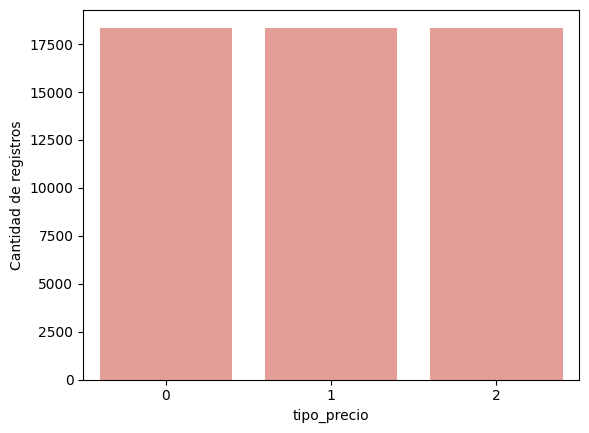

In [38]:
sns.countplot(x=df_train["tipo_precio"], data=df_train, color=CORAL)
plt.ylabel("Cantidad de registros")

#### 2

In [39]:
# Alternativa cuartil

primer_cuartil = df["total_m2_price"].quantile(0.25)
tercer_cuartil = df["total_m2_price"].quantile(0.75)
intervalos = [0, primer_cuartil, tercer_cuartil, float("inf")]

labels = [0, 1, 2]

df["tipo_precio"] = pd.cut(df["total_m2_price"], bins=[-float("inf"), primer_cuartil, tercer_cuartil, float("inf")], labels=labels, include_lowest=True)

df["tipo_precio"] = df["tipo_precio"].astype(int)

Text(0, 0.5, 'Cantidad de registros')

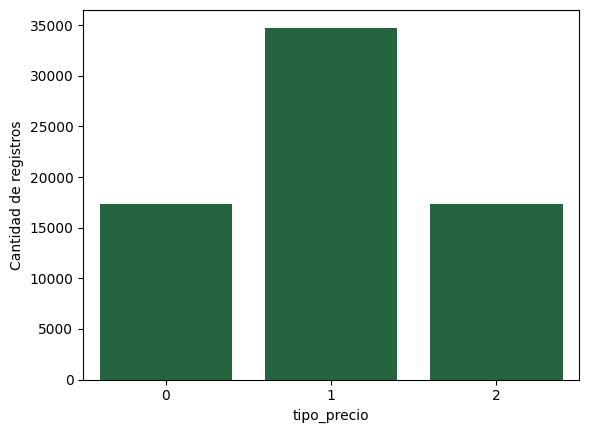

In [40]:
sns.countplot(x=df["tipo_precio"], data=df, color=VERDE)
plt.ylabel("Cantidad de registros")

In [41]:
df["tipo_precio"].value_counts()

tipo_precio
1    34767
0    17386
2    17339
Name: count, dtype: int64

#### 3

In [42]:
def calcular_tipo(grupo):
    primer_cuartil = grupo.quantile(0.25)
    tercer_cuartil = grupo.quantile(0.75)
    result = pd.Series(index=grupo.index)
    result[grupo <= primer_cuartil] = 0
    result[(grupo > primer_cuartil) & (grupo <= tercer_cuartil)] = 1
    result[grupo > tercer_cuartil] = 2
    return result

grouped = df_train.groupby(["Casa", "Departamento", "PH"])["total_m2_price"]
df_train["tipo_precio"] = grouped.apply(calcular_tipo).reset_index(drop=True).astype(int)


Text(0, 0.5, 'Cantidad de registros')

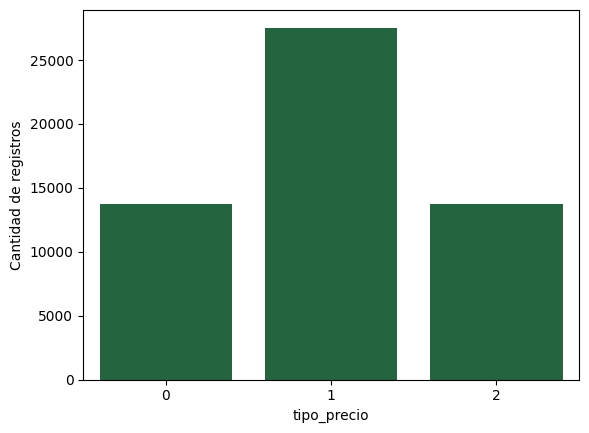

In [43]:
sns.countplot(x=df_train["tipo_precio"], data=df_train, color=VERDE)
plt.ylabel("Cantidad de registros")

In [44]:
df_train["tipo_precio"].value_counts()

tipo_precio
1    27540
0    13771
2    13748
Name: count, dtype: int64

Nos quedamos con la última forma de clasificación porque creemos que es la más certera por su (no me sale la palabra pero basicamente que es más específica la búsqueda)

In [45]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123) # me tira error con la constante

Text(0, 0.5, 'Cantidad de registros')

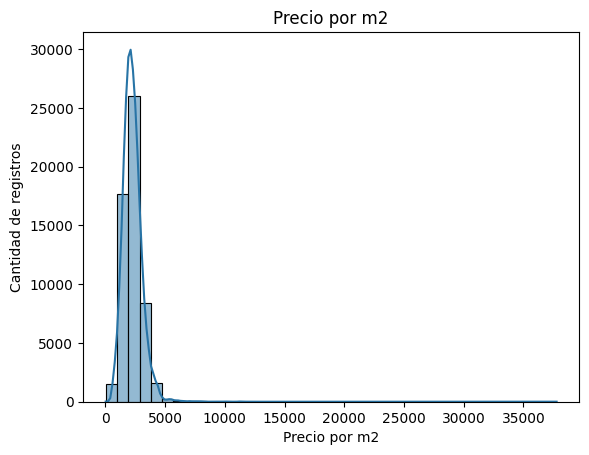

In [46]:
sns.histplot(df_train["total_m2_price"], kde=True, color=AZUL, bins=40)
plt.title("Precio por m2")
plt.xlabel("Precio por m2")
plt.ylabel("Cantidad de registros")

Text(0, 0.5, 'Cantidad de registros')

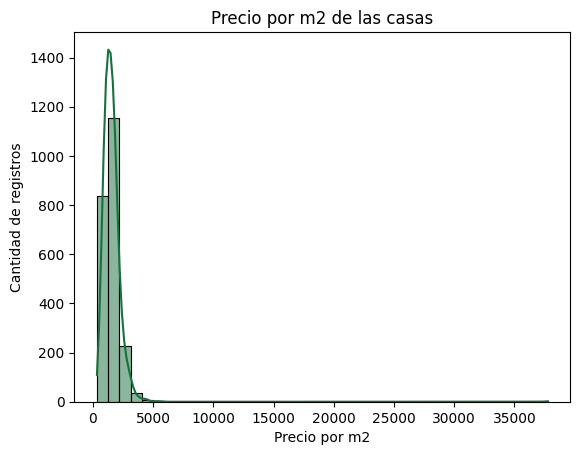

In [47]:
sns.histplot(df_train[df_train["Casa"] == 1]["total_m2_price"], kde=True, color=VERDE, bins=40)
plt.title("Precio por m2 de las casas")
plt.xlabel("Precio por m2")
plt.ylabel("Cantidad de registros")

Text(0, 0.5, 'Cantidad de registros')

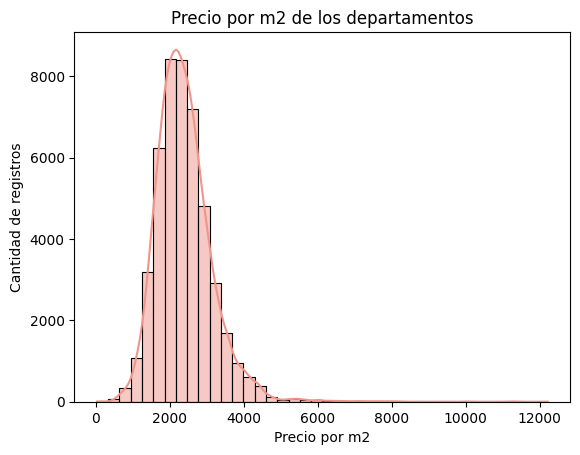

In [48]:
sns.histplot(df_train[df_train["Departamento"] == 1]["total_m2_price"], kde=True, color=CORAL, bins=40)
plt.title("Precio por m2 de los departamentos")
plt.xlabel("Precio por m2")
plt.ylabel("Cantidad de registros")

Text(0, 0.5, 'Cantidad de registros')

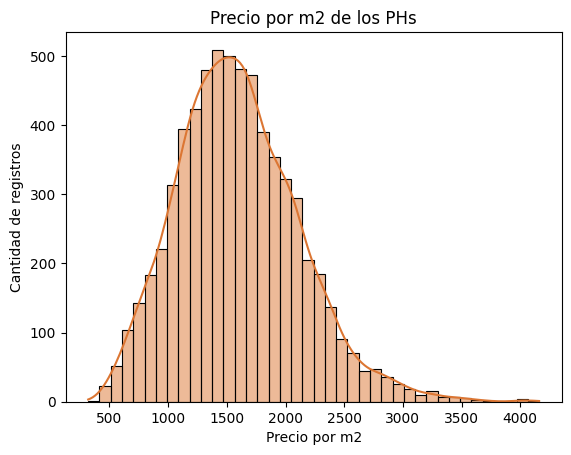

In [49]:
sns.histplot(df_train[df_train["PH"] == 1]["total_m2_price"], kde=True, color=NARANJA, bins=40)
plt.title("Precio por m2 de los PHs")
plt.xlabel("Precio por m2")
plt.ylabel("Cantidad de registros")

In [50]:
barrios_caba = gpd.read_file("barrios.geojson")
p = gpd.GeoSeries(barrios_caba.geometry)

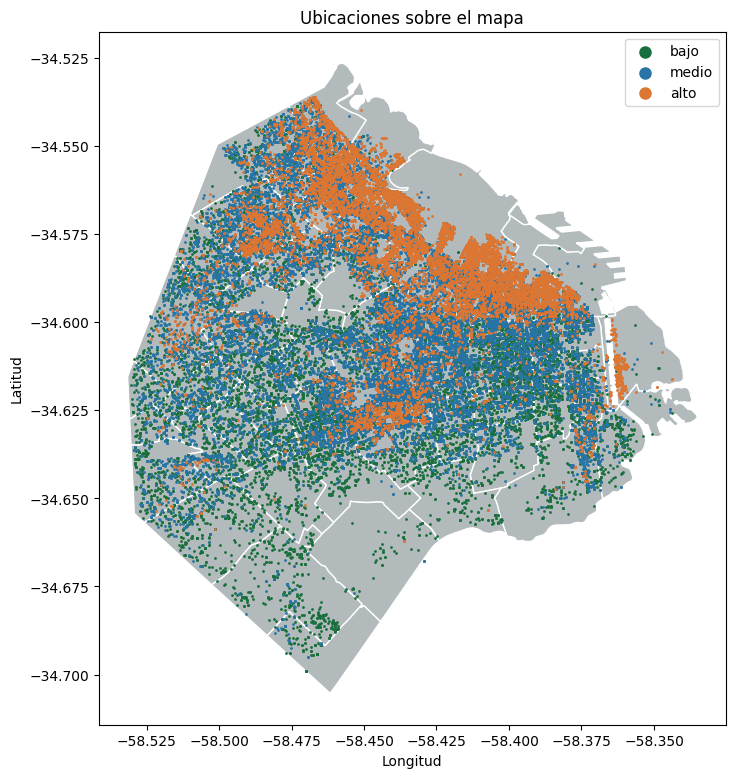

In [51]:
p.plot(color=GRIS, edgecolor="white", figsize=(9,9))

colores = COLORES[:3]
rangos = ["bajo", "medio", "alto"]

for i in range(3):
    plt.scatter(df[df["tipo_precio"] == i]["longitud"], df[df["tipo_precio"] == i]["latitud"], s = 1, c = colores[i], label = rangos[i])

plt.title("Ubicaciones sobre el mapa")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(markerscale = 8)
plt.show()

## Modelos clasificación

In [52]:
x_train = df_train.drop(columns=["tipo_precio"])
y_train = df_train["tipo_precio"]
x_test = df_test.drop(columns=["tipo_precio"])
y_test = df_test["tipo_precio"]

x_train.drop(columns=["total_m2_price","covered_m2_price","property_price"], inplace=True)
x_test.drop(columns=["total_m2_price","covered_m2_price","property_price"], inplace=True)

In [53]:
def printear_resultados(randomcv, x, y, b):
    _test, _train = "Métricas con set test: ", "Metricas con set train: "

    y_predict = randomcv.predict(x)

    print(randomcv.best_score_)
    if b:
        s = _test
    else:
        s = _train
    print(s)
    print(classification_report(y, y_predict))
    print(f"Accuracy: {accuracy_score(y, y_predict)}")

    cm = confusion_matrix(y, y_predict)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [54]:
def func_classif(param_distributions, cv, scorer_fn, estimator, n_iter):
  randomcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions = param_distributions,
                                scoring=scorer_fn,
                                cv=cv,
                                n_jobs = -1,
                                n_iter=n_iter,
                                random_state=42)

  randomcv.fit(x_train, y_train)

  printear_resultados(randomcv, x_test, y_test, True)

  print("-------------------------------------------------------------")

  printear_resultados(randomcv, x_train, y_train, False)

  return randomcv

### 1. Árbol de decisión

0.6889356700293789
Métricas con set test: 
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      3445
           1       0.71      0.73      0.72      6970
           2       0.69      0.65      0.67      3484

    accuracy                           0.70     13899
   macro avg       0.70      0.70      0.70     13899
weighted avg       0.70      0.70      0.70     13899

Accuracy: 0.7047269587740125
-------------------------------------------------------------
0.6889356700293789
Metricas con set train: 
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     13941
           1       0.89      0.91      0.90     27797
           2       0.90      0.84      0.87     13855

    accuracy                           0.89     55593
   macro avg       0.89      0.88      0.89     55593
weighted avg       0.89      0.89      0.89     55593

Accuracy: 0.8894824888025471


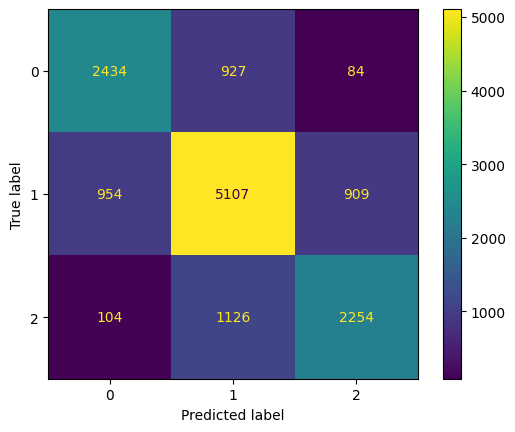

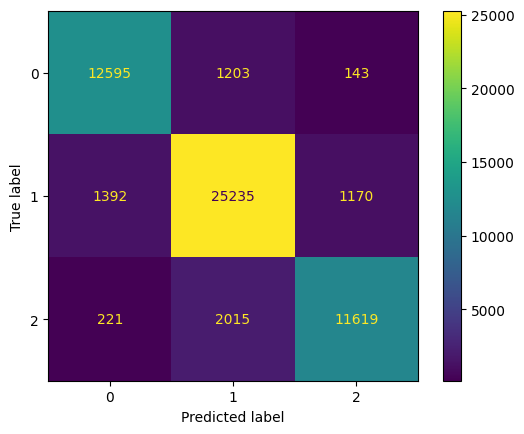

In [55]:
n_iter = 30

param_distributions = {"criterion":["gini","entropy","log_loss"],
               "min_samples_split": list(range(10,15)),
               "ccp_alpha":np.linspace(0,0.1,n_iter),
               "max_depth":list(range(15,30))}

cv = StratifiedKFold(n_splits=5)

scoring = make_scorer(accuracy_score)

estimator = DecisionTreeClassifier()

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)


Podemos ver los mejores hiperparametros elegidos, seguido por un grafico representativo del árbol

In [56]:
print(randomcv.best_params_)

{'min_samples_split': 10, 'max_depth': 26, 'criterion': 'entropy', 'ccp_alpha': 0.0}


In [57]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(randomcv.best_estimator_,
                                 feature_names=x_train.columns.to_list(),
                                 max_depth=2,
                                 filled=True,
                                 rounded=True,
                                 class_names=["Alto","Medio", "Bajo"])
plt.show(tree_plot_completo)

Podemos ver todos los atributos, desde el mas importante hasta el menos. Siendo los mas importantes Latitud y Longitud, que es lo mas esperado que se tenga en cuenta la ubicación en el mapa. Tambien se puede apreciar en el arbol que predomina la clase Medio, ya que es la que posee una mayor cantidad de muestras en comparación al resto.

In [58]:
sorted(list(zip(x_train.columns.to_list(), randomcv.best_estimator_.feature_importances_)), key=lambda x: -x[1])

[('latitud', 0.3502166315544818),
 ('longitud', 0.23028402314292443),
 ('property_surface_total', 0.14915071123773288),
 ('property_surface_covered', 0.11812628984966574),
 ('Departamento', 0.0808925150279892),
 ('Otro barrio', 0.03401982976706765),
 ('property_rooms', 0.019689199640210788),
 ('property_bedrooms', 0.012961646611016129),
 ('PH', 0.0022159649463943257),
 ('Casa', 0.0012854616428505273),
 ('Belgrano', 0.0006469102522681795),
 ('Caballito', 0.00040258820487163274),
 ('Palermo', 0.00010822812252659421)]

### 2. Random Forest

0.7489972766933966
Métricas con set test: 
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      3445
           1       0.75      0.81      0.78      6970
           2       0.76      0.69      0.73      3484

    accuracy                           0.76     13899
   macro avg       0.77      0.75      0.76     13899
weighted avg       0.76      0.76      0.76     13899

Accuracy: 0.7614216850133103
-------------------------------------------------------------
0.7489972766933966
Metricas con set train: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     13941
           1       0.96      0.98      0.97     27797
           2       0.97      0.96      0.96     13855

    accuracy                           0.97     55593
   macro avg       0.97      0.96      0.97     55593
weighted avg       0.97      0.97      0.97     55593

Accuracy: 0.9682513985573723


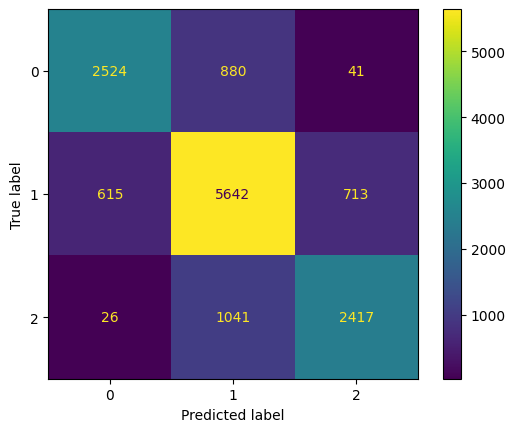

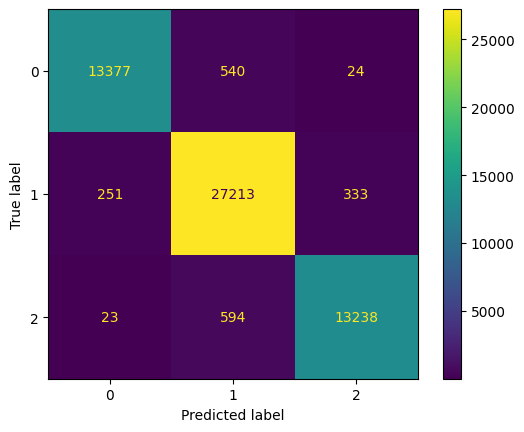

In [59]:
n_iter = 5

param_distributions = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 5, 10],
               "min_samples_split" : [2, 4, 10, 12, 16],
               "n_estimators": [10, 20, 50],
                "max_depth": range(15, 50) }


cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = RandomForestClassifier(random_state=1)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [60]:
print(randomcv.best_params_)

{'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 40, 'criterion': 'gini'}


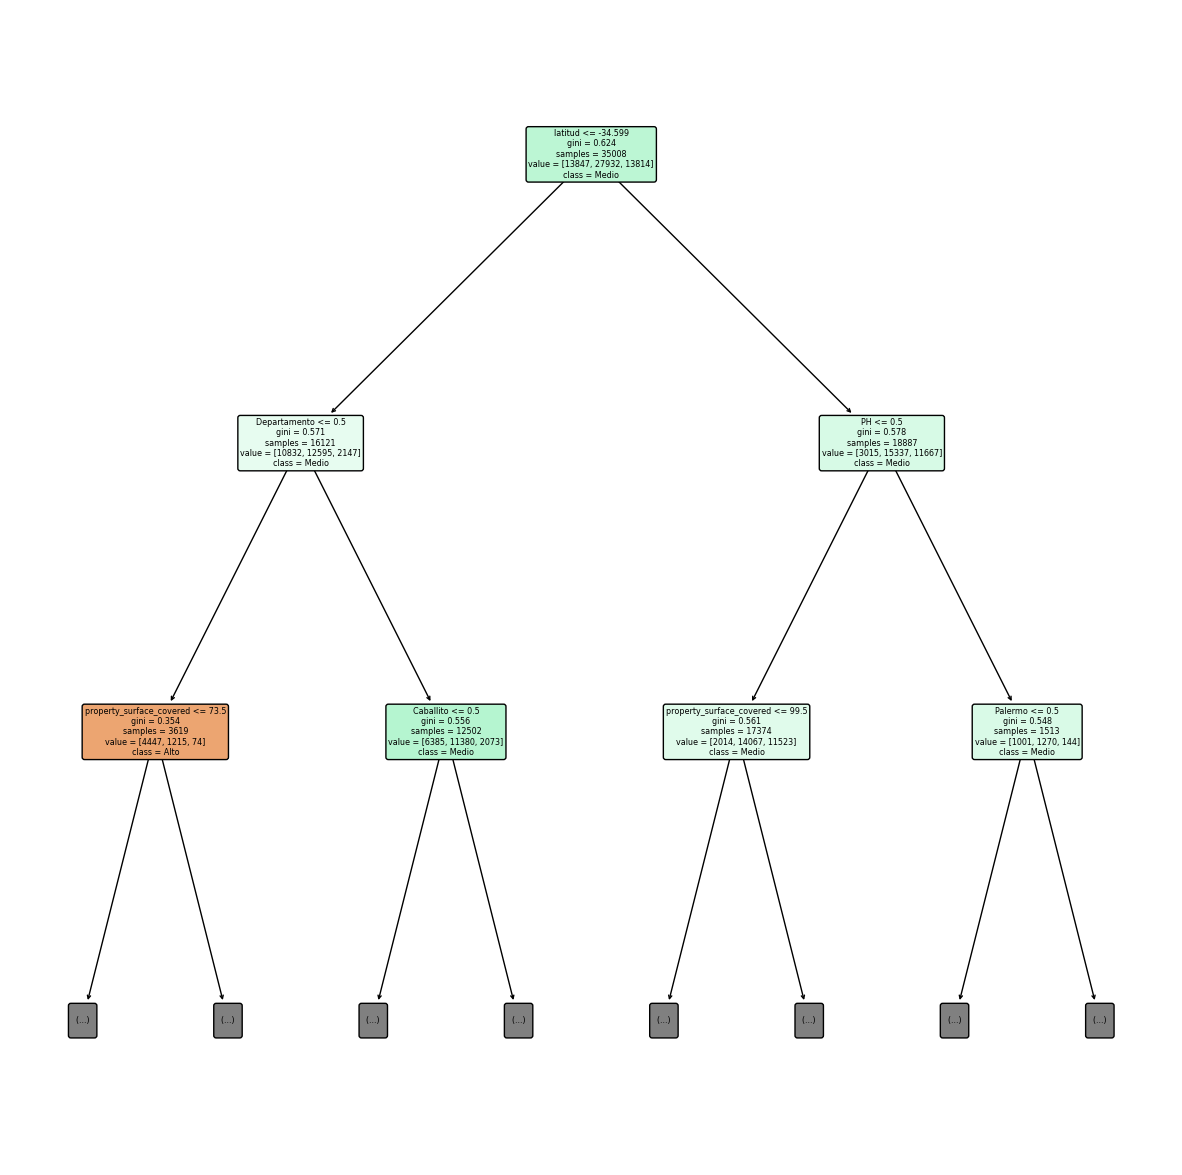

In [61]:
plt.figure(figsize=(15,15))

tree_plot_completo=tree.plot_tree(randomcv.best_estimator_.estimators_[0],
                                 feature_names=x_train.columns.to_list(),
                                 max_depth=2,
                                 filled=True,
                                 rounded=True,
                                 class_names=["Alto","Medio", "Bajo"])
plt.show(tree_plot_completo)

### 3. Elección: KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier

0.6878564768260944
Métricas con set test: 
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      3445
           1       0.70      0.74      0.72      6970
           2       0.67      0.62      0.64      3484

    accuracy                           0.69     13899
   macro avg       0.69      0.68      0.68     13899
weighted avg       0.69      0.69      0.69     13899

Accuracy: 0.6934311820994317
-------------------------------------------------------------
0.6878564768260944
Metricas con set train: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13941
           1       0.98      0.98      0.98     27797
           2       0.99      0.96      0.98     13855

    accuracy                           0.98     55593
   macro avg       0.98      0.98      0.98     55593
weighted avg       0.98      0.98      0.98     55593

Accuracy: 0.9801773604590506


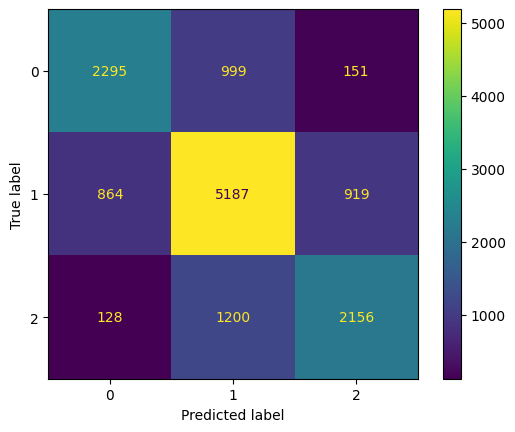

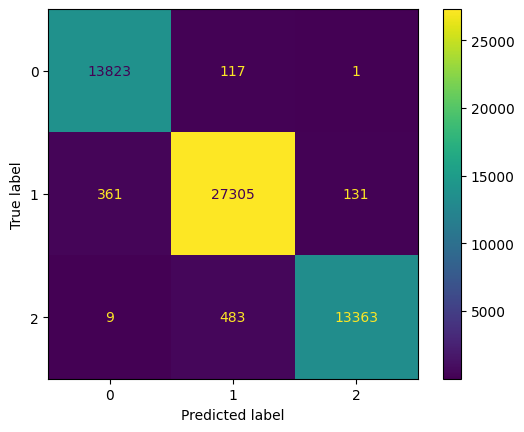

In [63]:
n_iter = 10

param_distributions = {
    "n_neighbors": range(1, 11),
    "weights": ["uniform", "distance"],  # Peso de los vecinos (uniforme o ponderado por distancia)
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],  # Algoritmo para calcular los vecinos más cercanos
    "p": [1, 2]  # Parámetro de distancia (1 para Manhattan, 2 para Euclidiana)
}

cv = 10

scoring = "accuracy"

estimator = KNeighborsClassifier()

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [64]:
print(randomcv.best_params_)

{'weights': 'distance', 'p': 1, 'n_neighbors': 8, 'algorithm': 'auto'}


## Modelos regresión

In [65]:
df_train.columns

Index(['latitud', 'longitud', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price',
       'total_m2_price', 'covered_m2_price', 'Casa', 'Departamento', 'PH',
       'Palermo', 'Belgrano', 'Caballito', 'Otro barrio', 'tipo_precio'],
      dtype='object')

In [66]:
x_train = df_train.drop(columns=["property_price","total_m2_price","covered_m2_price","tipo_precio"])
y_train = df_train["property_price"]
x_test = df_test.drop(columns=["property_price","total_m2_price","covered_m2_price","tipo_precio"])
y_test = df_test["property_price"]

In [67]:
# Normalizar los datos de entrenamiento y prueba
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.transform(x_test)

In [68]:
def bestScores(modelStr, model, parameters, x_train, x_test, y_train, y_test, scoring):
    rscv = RandomizedSearchCV(estimator=model,
                            param_distributions=parameters,
                            scoring=scoring,
                            cv=5,
                            n_jobs=-1,
                            n_iter=10,
                            random_state=123)

    rscv.fit(x_train, y_train)
    y_predict = rscv.predict(x_test)

    best_score = rscv.best_score_
    best_params = rscv.best_params_
    print(modelStr + ": ")
    print("Mejor puntaje obtenido:", best_score)
    print("Mejores parámetros utilizados:", best_params)
    print("\n")

    return rscv

In [69]:
def runRegresionModels(model, parameters, x_train, x_test, y_train, y_test):
  #MSE
  from sklearn.metrics import mean_squared_error

  scorer = make_scorer(mean_squared_error, greater_is_better=False)

  bestScores("MSE", model, parameters, x_train, x_test, y_train, y_test, scorer)


  #RMSE
  import numpy as np
  def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

  scorer = make_scorer(rmse, greater_is_better=False)

  bestScores("RMSE", model, parameters, x_train, x_test, y_train, y_test, scorer)



  #r2
  from sklearn.metrics import r2_score
  scorer = make_scorer(r2_score)

  return bestScores("r2", model, parameters, x_train, x_test, y_train, y_test, scorer)

In [70]:
def evaluate_r2_with_best_params(str, x, y, rscv):

    y_predict = rscv.predict(x)

    r2 = r2_score(y, y_predict)

    print(str, " - Score R2:", r2)

### 1. KNN

In [71]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor

In [72]:
model = KNeighborsRegressor()

parameters = { "n_neighbors":range(1, 30),
              "weights":["distance","uniform"],
              "algorithm":["ball_tree", "kd_tree", "brute"],
              "metric":["euclidean","manhattan","chebyshev"]
             }

# Dejo comentado para evitar la demora al correr el modelo. En caso de querer hacer la prueba, descomentar y ejecutar. Tiene un alto tiempo de ejecución.
# rscv = runRegresionModels(model, parameters, x_train_normalized, x_test_normalized, y_train, y_test)


# print("Puntaje r2 con los mejores parámetros: ")
# evaluate_r2_with_best_params("Train: ",x_train_normalized, y_train, rscv)
# evaluate_r2_with_best_params("Test: ",x_test_normalized, y_test, rscv)


Resultados obtenidos al descomentar la ejecución:

MSE:

Mejor puntaje obtenido: -5761099670.790462

Mejores parámetros utilizados: {"weights": "distance", "n_neighbors": 19, "metric": "euclidean", "algorithm": "ball_tree"}

---

RMSE:

Mejor puntaje obtenido: -74518.06351815231

Mejores parámetros utilizados: {"weights": "distance", "n_neighbors": 19, "metric": "euclidean", "algorithm": "ball_tree"}

---

r2:

Mejor puntaje obtenido: 0.8432692616844328

Mejores parámetros utilizados: {"weights": "distance", "n_neighbors": 19, "metric": "euclidean", "algorithm": "ball_tree"}

---

Puntaje r2 con los mejores parámetros:

Train:   - Score R2: 0.9980464928000717

Test:   - Score R2: 0.8847894015232972

### 2. XGBoost

In [73]:
model = xgb.XGBRegressor()

parameters = {
    "n_estimators": [100, 200, 300],  # Número de árboles en el bosque
    "max_depth": [3, 4, 5],  # Profundidad máxima de cada árbol
    "learning_rate": [0.1, 0.01, 0.001],  # Tasa de aprendizaje
    "subsample": [0.7, 0.8, 0.9],  # Proporción de muestras utilizadas para entrenar cada árbol
    "colsample_bytree": [0.7, 0.8, 0.9],  # Proporción de características utilizadas para entrenar cada árbol
    "gamma": [0, 0.1, 0.2],  # Parámetro de regularización para evitar el sobreajuste
    "reg_alpha": [0, 0.1, 0.5],  # Término de regularización L1 en pesos del árbol
    "reg_lambda": [1, 1.5, 2],  # Término de regularización L2 en pesos del árbol
}

rscv = runRegresionModels(model, parameters, x_train_normalized, x_test_normalized, y_train, y_test)

print("Puntaje r2 con los mejores parámetros: ")
evaluate_r2_with_best_params("Train: ",x_train_normalized, y_train, rscv)
evaluate_r2_with_best_params("Test: ",x_test_normalized, y_test, rscv)


MSE: 
Mejor puntaje obtenido: -6153214271.456705
Mejores parámetros utilizados: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}


RMSE: 
Mejor puntaje obtenido: -77324.05561521513
Mejores parámetros utilizados: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}


r2: 
Mejor puntaje obtenido: 0.8318621858052028
Mejores parámetros utilizados: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}


Puntaje r2 con los mejores parámetros: 
Train:   - Score R2: 0.9032812939110471
Test:   - Score R2: 0.8230031173164822


### LightGBM

In [74]:
model = LGBMRegressor()

parametros = {
  "learning_rate": [0.01, 0.05, 0.1],
  "depth": [4, 6, 8, 10],
  "l2_leaf_reg": [1, 3, 5, 7, 9],
  "random_strength": [0.1, 0.5, 1],
  "bagging_temperature": [0.5, 1, 1.5],
  "border_count": [32, 64, 128],
  "verbosity": [-1] # solo para que no tire 8000 warnings
}

rscv = runRegresionModels(model, parametros, x_train_normalized, x_test_normalized, y_train, y_test)

bestRegresionModel = rscv

print("Puntaje r2 con los mejores parámetros: ")
evaluate_r2_with_best_params("Train: ",x_train_normalized, y_train, rscv)
evaluate_r2_with_best_params("Test: ",x_test_normalized, y_test, rscv)

MSE: 
Mejor puntaje obtenido: -6082288721.437082
Mejores parámetros utilizados: {'verbosity': -1, 'random_strength': 0.1, 'learning_rate': 0.1, 'l2_leaf_reg': 9, 'depth': 4, 'border_count': 32, 'bagging_temperature': 1.5}


RMSE: 
Mejor puntaje obtenido: -76946.29875034408
Mejores parámetros utilizados: {'verbosity': -1, 'random_strength': 0.1, 'learning_rate': 0.1, 'l2_leaf_reg': 9, 'depth': 4, 'border_count': 32, 'bagging_temperature': 1.5}


r2: 
Mejor puntaje obtenido: 0.8336191651360334
Mejores parámetros utilizados: {'verbosity': -1, 'random_strength': 0.1, 'learning_rate': 0.1, 'l2_leaf_reg': 9, 'depth': 4, 'border_count': 32, 'bagging_temperature': 1.5}


Puntaje r2 con los mejores parámetros: 
Train:   - Score R2: 0.8883875846444514
Test:   - Score R2: 0.8687874094215444


### Pulimiento del modelo

Contando con la buena respuesta del modelo LightGBM, vamos a realizar una búsqueda más exhaustiva de parámetros que mejor ajusten al mismo

In [75]:
model = LGBMRegressor()

parametros = {
  "learning_rate": [0.01, 0.05, 0.1, 0.2],
  "depth": [4, 6, 8, 10, 12],
  "l2_leaf_reg": [1, 3, 5, 7, 9, 11],
  "random_strength": [0.1, 0.5, 1, 1.5, 2],
  "bagging_temperature": [0.5, 1, 1.5, 2.0, 2.5],
  "border_count": [32, 64, 128, 256, 512],
  "min_child_samples": [5, 10, 20],
  "subsample": [0.6, 0.8, 1.0],
  "colsample_bytree": [0.6, 0.8, 1.0],
  "reg_alpha": [0.0, 0.1, 0.5, 1.0],
  "reg_lambda": [0.0, 0.1, 0.5, 1.0],
  "scale_pos_weight": [1, 2, 5],
  "verbosity": [-1] # solo para que no tire 8000 warnings
}

from sklearn.metrics import r2_score
scorer = make_scorer(r2_score)

rscv = bestScores("r2", model, parametros, x_train_normalized, x_test_normalized, y_train, y_test, scorer)


print("Puntaje r2 con los mejores parámetros: ")
evaluate_r2_with_best_params("Train: ",x_train_normalized, y_train, rscv)
evaluate_r2_with_best_params("Test: ",x_test_normalized, y_test, rscv)

r2: 
Mejor puntaje obtenido: 0.8378612400291562
Mejores parámetros utilizados: {'verbosity': -1, 'subsample': 0.6, 'scale_pos_weight': 5, 'reg_lambda': 0.0, 'reg_alpha': 0.5, 'random_strength': 2, 'min_child_samples': 20, 'learning_rate': 0.2, 'l2_leaf_reg': 9, 'depth': 4, 'colsample_bytree': 0.8, 'border_count': 64, 'bagging_temperature': 1}


Puntaje r2 con los mejores parámetros: 
Train:   - Score R2: 0.9086841173660252
Test:   - Score R2: 0.8604044506608113


Podemos ver un aumento en el score en el set de entrenamiento y una disminución en el de test. Una clara señal de que este cambio lleva al overfitting del modelo, por lo cual optamos por conservamos los parametros del paso previo.

### Evaluación de muestras con el modelo re regresión seleccionado: LightGBM

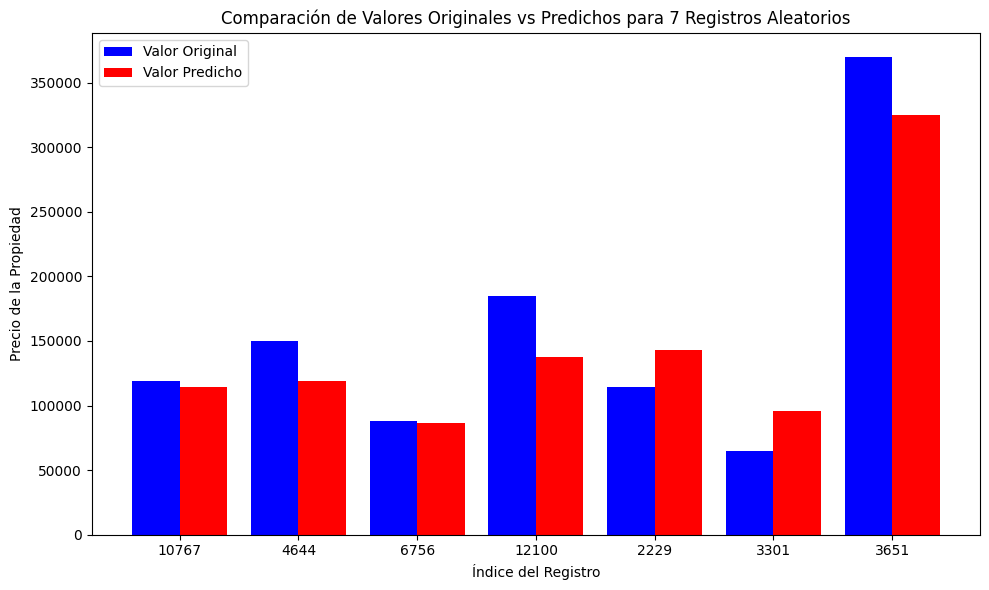

In [76]:
predictions = bestRegresionModel.predict(x_test_normalized)

np.random.seed(10)
indices_aleatorios = np.random.choice(range(len(y_test)), size=7, replace=False)

valores_originales = y_test.iloc[indices_aleatorios]
valores_predichos = predictions[indices_aleatorios]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(7) - 0.2, valores_originales, width=0.4, color='b', align='center', label='Valor Original')
plt.bar(np.arange(7) + 0.2, valores_predichos, width=0.4, color='r', align='center', label='Valor Predicho')

plt.xlabel('Índice del Registro')
plt.ylabel('Precio de la Propiedad')
plt.title('Comparación de Valores Originales vs Predichos para 7 Registros Aleatorios')
plt.xticks(np.arange(7), indices_aleatorios)
plt.legend()

plt.tight_layout()
plt.show()